# Workflow

In ML projects we will spend an large fraction of your time **acquiring, cleaning, and transforming data**.

## Get the data

We use California census data to build a model of housing prices in the state. This data includes metrics such as the population, median income, and median housing price for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data. We will call them "districts" for short. 

The model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.

In typical environments your data would be available in a database and spread across multiple tables/documents/files. To access it, you would first familiarize yourself with the data schema. In this project, we will just download a single compressed file which contains a comma-separated values (CSV) file called housing.csv with all the data. 

It is always preferable to create a small function to download the file and decompress it. Having a function is useful in particular if the data changes regularly: you can write a small script that uses the function to fetch the latest data. Automating the process of fetching the data is also useful if you need to install the dataset on multiple machines.

In [1]:
!mkdir data

mkdir: data: File exists


In [2]:
import urllib.request
import tarfile

def fetch_data(remote, local):
    urllib.request.urlretrieve(remote, local)
    tgz = tarfile.open(local)
    tgz.extractall("./data")
    tgz.close()
    
fetch_data("https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz", "data/housing.tgz" )

### Laod the data

Now let’s load the data using Pandas. We write a small function to load the data. Now we have a **DataFrame object** containing all the data. We can take a look at the top rows using the **head()** method.

In [3]:
import pandas as pd

def load_data(csv):
    return pd.read_csv(csv)

data_set = load_data("data/housing.csv")

data_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The **info()** method is useful to get a quick description of the data, in
particular the total number of rows, each attribute’s type, and the number of
nonnull values

In [4]:
data_set.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The **describe()** method shows a summary of the numerical attributes.

In [5]:
data_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


To get informaion about categorical attribute, it is possible to use the **value_counts()** method

In [6]:
data_set["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### Show data

A quick way to get a feel of the type of data we are dealing with is to **plot a histogram for each numerical attribute**. We can call the **hist()** method on the whole dataset.

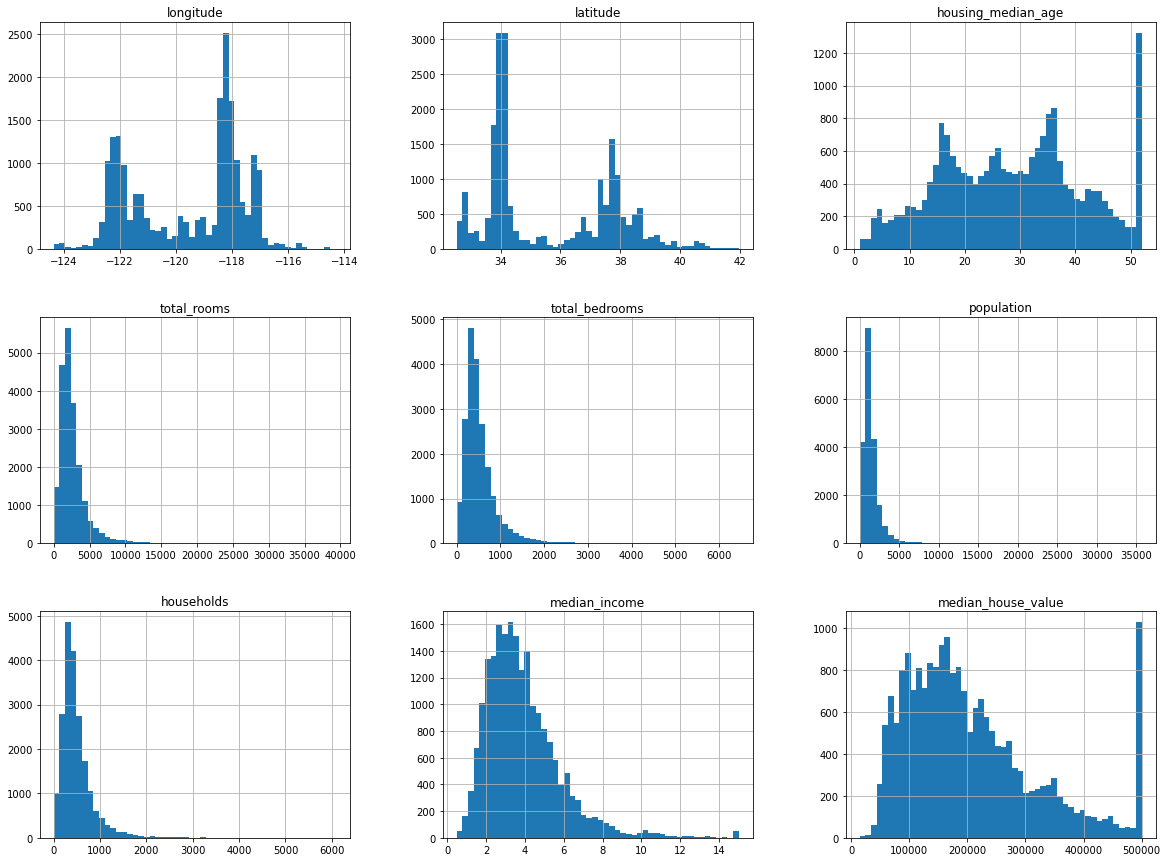

In [7]:
data_set.hist(bins=50, figsize=(20,15));

There are a few things we might notice in these histograms:

- the "median income" does not look like it is expressed in dollars (numbers represent roughly tens of thousands of dollars) and data has been **scaled and capped** at 15 for higher median incomes.

- The "housing median age" and the "median house value" were also **capped**. The latter may be a serious problem since it is the **target attribute**. The algorithms may learn that prices never go beyond that limit. Two options: collect proper labels, remove those districts from the dataset.

- Attributes have **very different scales**. 

- Many histograms are **tail-heavy** (extend much farther to the right of the median than to the left). This may make it a bit harder for some ML algorithms to detect patterns. 

Working with preprocessed attributes is common in ML, and it is not necessarily a problem, but we should try to understand how the data was computed.

### Create a test set

A common danger in machine learning is **overfitting** (a model that performs well on the training data, but generalizes poorly to any new data). This could involve learning noise in the data, or it could involve learning to identify specific inputs rather than whatever factors are actually predictive for the desired output. The other side of this is **underfitting** (a model that doesn’t perform well even on the training data), although typically when this happens we decide that our model isn’t good enough and keep looking for a better one. Clearly, models that are too complex lead to overfitting and don’t generalize well beyond the data they were trained on. So how do we make sure our models aren’t too complex? The most fundamental approach involves using different data to train the model and to test the model.

Before we look at the data any further, we need to create a **test set**, put it aside, and **never look at it!** It may sound strange to voluntarily set aside part of the data at this stage. After all, we have only taken a quick glance at the data, and surely we should learn a whole lot more about it before we decide what algorithms to use. This is true, but **our brain is an amazing pattern detection system**, which means that it is highly prone to overfitting: if we look at the test set, we may notice interesting pattern in the test data that leads us to select a particular kind of Machine Learning model. This is called **data snooping bias**.

Creating a test set is theoretically simple: pick some instances randomly (typically 20%) of the dataset and set them aside.

In [8]:
import random

def split_data(data, prob):
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.


In [9]:
train, test = split_data(data_set.values.tolist(), 0.80)
print(len(train))
print(len(test))

16512
4128


Often, we’ll have paired input variables and output variables. In that case, we need to make sure to put corresponding values together in either the training data or the test data:

In [10]:
def train_test_split(xs, ys, test_pct):
    # Generate the indices and split them.
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)
    return ([xs[i] for i in train_idxs],  # x_train
            [xs[i] for i in test_idxs],   # x_test
            [ys[i] for i in train_idxs],  # y_train
            [ys[i] for i in test_idxs])   # y_test

If a model was overfit to the training data, then it will hopefully perform really poorly on the (completely separate) test data. Said differently, if it performs well on the test data, then you can be more confident that it’s fitting rather than overfitting. This works, but it is not perfect: if we run the program again, it will generate a different test set! Over time, we will get to see the whole dataset, which is what we want to avoid.

One solution is to **save the test set on the first run and then load it in subsequent runs**. Another option is to **set the random number generator’s seed** so that it always generates the same shuffled indices. But these solutions will break the next time we fetch an updated dataset.

To have a **stable train/test split** even after updating the dataset, a common solution is to use each instance’s **identifier** to decide whether or not it should
go in the test set. For example, we could compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value. This ensures that the test set will remain consistent across multiple runs, even if we refresh the dataset. 

**Scikit-Learn** provides a few functions to split datasets into multiple subsets in various ways. The simplest function is **train_test_split()**, :

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data_set, test_size=0.2, random_state=42)

In [12]:
len(train_set)

16512

In [13]:
len(test_set)

4128

So far we have considered **purely random sampling methods**. This is generally fine if our dataset is large enough, but if it is not, we run the risk of introducing a significant **sampling bias**.  Suppose that the "median income" is a very important attribute to predict median housing prices. We may want to ensure that **the test set is representative** of the various categories of incomes in the whole dataset. Since it is a continuous numerical attribute, we need to create a category attribute. Let’s look at the histogram more closely.

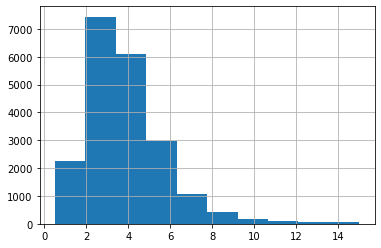

In [14]:
data_set["median_income"].hist();

We can use the **cut()** method in order to create an "income" **category attribute** with five categories (labeled from 1 to 5).

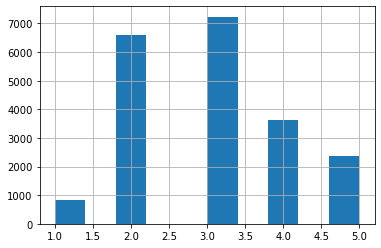

In [15]:
import numpy as np

data_set["income_cat"] = pd.cut(data_set["median_income"],
                                bins=[0., 1.5, 3.0, 4.5, 6., np.inf], 
                                labels=[1, 2, 3, 4, 5])
data_set["income_cat"].hist();

We can now use [**stratified sampling**](https://www.nagwa.com/en/videos/380126093948/): the population is divided into homogeneous subgroups called **strata**, and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population. 

<img src="./images/stratified-sampling.png" width="900"> 

We can use the Scikit-Learn’s **StratifiedShuffleSplit class**

In [16]:
import sklearn as skl

# stratified sampling
split = skl.model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)

for train_index, test_index in split.split(data_set, data_set["income_cat"]):
    strat_train_set = data_set.loc[train_index]
    strat_test_set = data_set.loc[test_index]

# random sampling
random_train_set, random_test_set = skl.model_selection.train_test_split(data_set, test_size=0.2, random_state=42)


proportions = { 'strat_test_set': strat_test_set["income_cat"].value_counts() / len(strat_test_set),     
                'strat_train_set': strat_train_set["income_cat"].value_counts() / len(strat_train_set),
                'data_set': data_set["income_cat"].value_counts() / len(data_set),
                'random_train_set': random_train_set["income_cat"].value_counts() / len(random_train_set),
                'random_test_set': random_test_set["income_cat"].value_counts() / len(random_test_set) }

proportions_df = pd.DataFrame(data=proportions, index=[1, 2, 3, 4, 5])

proportions_df.head()

,strat_test_set,strat_train_set,data_set,random_train_set,random_test_set
1,0.039971,0.039789,0.039826,0.039729,0.040213
2,0.318798,0.318859,0.318847,0.317466,0.324370
3,0.350533,0.350594,0.350581,0.348595,0.358527
4,0.176357,0.176296,0.176308,0.178537,0.167393
5,0.114341,0.114462,0.114438,0.115673,0.109496


As we can see, the test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is skewed.

Now we should remove the income_cat attribute so the data is back to its original state.

In [17]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and visualize data

First, make sure we have put the test set aside and we are only exploring the training set. Also, if the training set is very large, we may want to sample an **exploration set**, to make manipulations easy and fast. In our case, the set is quite small, so we can just work directly on the full set. Let’s create a copy so that you can play with it without harming the training set.

In [18]:
exploration_set = strat_train_set.copy()

### Visualize geographical information

Since there is geographical information (latitude and longitude), it is a good idea to create a scatterplot of all districts to visualize the data. Setting the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data points.

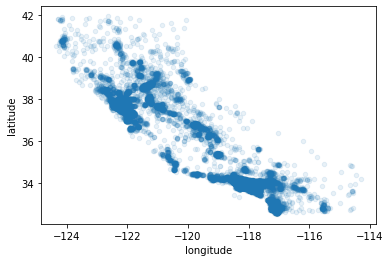

In [19]:
exploration_set.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1);

Now let’s look at other attribure using circle color and size. 
The radius of each circle represents the district’s population (option s), and the color represents the price
(option c).

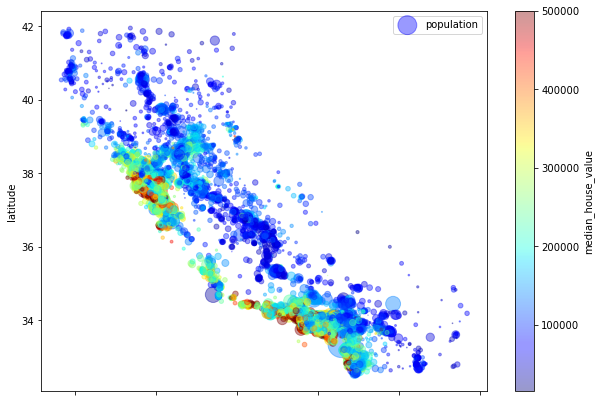

In [20]:
import matplotlib.pyplot as plt

exploration_set.plot(kind="scatter", 
                     x="longitude", 
                     y="latitude", 
                     alpha=0.4,
                     s=exploration_set["population"]/50, 
                     label="population", 
                     figsize=(10,7),
                     c="median_house_value", 
                     cmap=plt.get_cmap("jet"), 
                     colorbar=True)
plt.legend();

The image tells that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density.
A clustering algorithm should be useful for detecting the main cluster and for adding new features that measure the proximity to the
cluster centers.

### Looking for correlations
Since the dataset is not too large, we can easily compute the **standard correlation coefficient** between every pair of attributes using the **corr()** method. Thie coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; when the coefficient is close to –1, it means that there is a strong negative correlation;  coefficients close to 0 mean that there is no linear correlation. The correlation coefficient **only measures linear correlations** (“if x goes up, then y generally goes up/down”). It may completely miss out on nonlinear relationships.

In [21]:
corr_matrix = exploration_set.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

The "median house value" tends to go up when the "median income" goes up; we can see also a small negative correlation between the "latitude" and the "median house value"

Another way to check for correlation between attributes is to use the **scatter_matrix()** function, which plots every numerical attribute against every other numerical attribute. We can focus on a few promising attributes that seem most correlated with the "median housing value". The main diagonal  would be full of straight lines if pandas plotted each variable against itself, which would not be very useful. So instead pandas displays a histogram of each attribute.

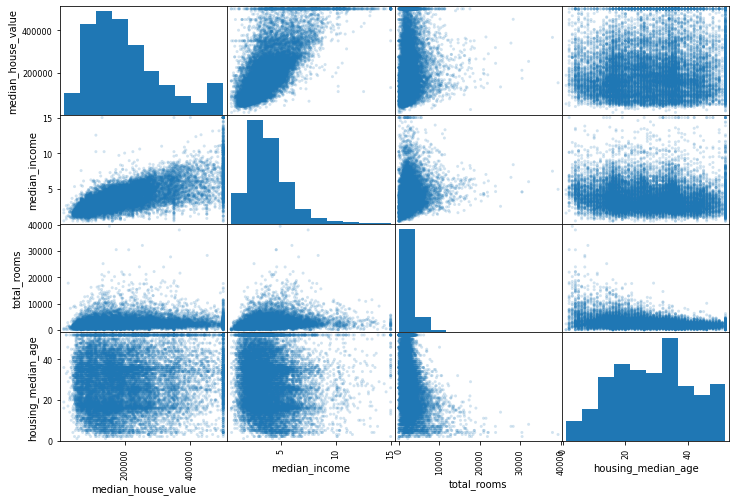

In [22]:
pd.plotting.scatter_matrix(exploration_set[["median_house_value", "median_income", "total_rooms", "housing_median_age"]], 
                           figsize=(12, 8),
                           alpha=0.2);

The most promising attribute to predict the "median house value" is the "median income"

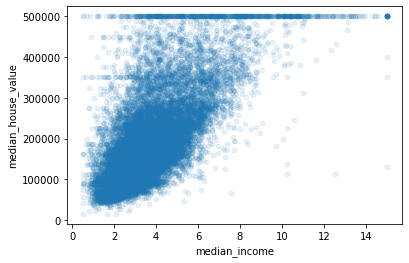

In [23]:
exploration_set.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1);

This plot reveals a few things:
- the correlation is very strong, you can clearly see the upward trend, and the points are not too dispersed,
- the price cap that we noticed earlier is clearly visible as a horizontal line at the top,
- the plot reveals other less obvious straight horizontl lines, we may want to try removing the corresponding districts to prevent our algorithms from learning to reproduce these data quirks.

### Attribute combinations

One last thing we can do before preparing the data for ML algorithms is to try out various **attribute combinations**. For example, the "total number of rooms" in a district is not very useful if we don’t know how many households there are. What we really want is the number of "rooms per household". Similarly, the "total number of bedrooms" by itself is not very useful: we probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. Let’s create these new attributes.

In [24]:
exploration_set["rooms_per_household"] = exploration_set["total_rooms"]/exploration_set["households"]
exploration_set["bedrooms_per_room"] = exploration_set["total_bedrooms"]/exploration_set["total_rooms"]
exploration_set["population_per_household"] = exploration_set["population"]/exploration_set["households"]

corr_matrix = exploration_set.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

The new "bedrooms_per_room" attribute is much more correlated than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

This round of exploration does not have to be absolutely exhaustive. The point is to start off on the right foot and quickly gain insights that will help to get a first reasonably good prototype. But this is an **iterative process**: once we get a prototype up and running, we can analyze its output to gain more insights and come back to the exploration step.

## Prepare data

It’s time to prepare the data for the machine learning algorithm. We should write functions for this purpose to allow us to reproduce these transformations easily on any dataset and to use these functions in our live system to transform the new data before feeding it to our algorithms. First revert to a clean training set and separate the predictors and the labels.

In [25]:
predictors = strat_train_set.drop("median_house_value", axis=1)
labels = strat_train_set["median_house_value"].copy()

### Data cleaning

ML algorithms cannot work with **missing features**. We have three options: delete the corresponding sample, remove the whole attribute or set the missing values to some value (zero, the mean, the median, etc.). We can accomplish these easily using **dropna()**, **drop()**, and **fillna()** methods. 

In [26]:
# predictors.dropna(subset=["total_bedrooms"]) # first option
# predictors.drop("total_bedrooms", axis=1) # second option
# predictors["total_bedrooms"].fillna(predictors["total_bedrooms"].median(), inplace=True) #third option

Otherwise, Scikit-Learn provides a handy class to take care of missing values called **SimpleImputer**. We can specifying that we want to replace each missing values with the median of that attribute, however, since the median can only be computed on numerical attributes, we need to create a copy of the dataset without non-numerical attributes. The imputer computed the median of each attribute and stored the result in its statistics_ instance variable. In the example, we know than only "total_bedrooms" had missing values, but we cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the imputer to all the numerical attributes.

In [27]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
predictors_num = predictors.drop("ocean_proximity", axis=1)
predictors_num = pd.DataFrame(imputer.fit_transform(predictors_num), 
                              columns=predictors_num.columns,
                              index=predictors_num.index)

### Handling text and categorical attributes

If an attribute doesn't contains arbitrary text, but there are a limited number of possible values, then this attribute is a **categorical attribute**. Most algorithms prefer to work with numbers, so we need to convert these categories from text to numbers. It is possible to use the Scikit-Learn’s **OrdinalEncoder**. The encoder manteins the list of categories using the "categories_" instance variable. In the example, we have the "ocean_proximity" attribute.

In [28]:
from sklearn.preprocessing import OrdinalEncoder

predictors_cat = predictors[["ocean_proximity"]]
print(predictors_cat[:10])

ordinal_encoder = OrdinalEncoder()
predictors_cat_encoded = ordinal_encoder.fit_transform(predictors_cat)
print(predictors_cat_encoded[:10])
print(ordinal_encoder.categories_)

      ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN
1481         NEAR BAY
18125       <1H OCEAN
5830        <1H OCEAN
17989       <1H OCEAN
4861        <1H OCEAN
[[1.]
 [4.]
 [1.]
 [4.]
 [0.]
 [3.]
 [0.]
 [0.]
 [0.]
 [0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


One issue with this representation is that algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad,” “average,” “good,” and “excellent”). It is not the case for the "ocean_proximity" column. To fix this issue, a common solution is the **one-hot encoding** that create one binary attribute per category (attributes equal to 1 for the correspondinf category and 0 otherwise). Scikit-Learn provides the **OneHotEncoder** class. The output is a **sparse matrix** (the matrix is full of 0s except for a single 1 per row, using memory mostly to store zeros; the sparse representation only stores the location of the nonzero elements). If we really want to convert it to a (dense array, just call the **toarray()** method.

<img src="./images/one-hot-encoding.png" width="500">

If a categorical attribute has a large number of possible categories, then one-hot encoding will result in a large number of input features. This may slow down training and degrade performance. If this happens, we can replace the categorical input with useful numerical features related to the categories: for example, we could replace the ocean_proximity feature with the distance to the ocean.  

In [29]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
predictors_cat_1hot = cat_encoder.fit_transform(predictors_cat)
print(predictors_cat_1hot[:10])
predictors_cat_1hot.toarray()

  (0, 1)	1.0
  (1, 4)	1.0
  (2, 1)	1.0
  (3, 4)	1.0
  (4, 0)	1.0
  (5, 3)	1.0
  (6, 0)	1.0
  (7, 0)	1.0
  (8, 0)	1.0
  (9, 0)	1.0


array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Custom transformers
Although Scikit-Learn provides many useful transformers, we will need to **write our own transformer** for tasks such as custom cleanup operations or combining specific attributes. To work seamlessly with Scikit-Learn, we need to create a class and implement three methods: **fit()**, **transform()** and **fit_transform()**. We can get the last one for free by simply adding **TransformerMixin** as a base class. If we add **BaseEstimator** as a base class we will also get two extra methods (get_params() and set_params()) that will be useful for automatic hyperparameter tuning.

The transformer can have hyperparameters (it is often helpful to provide sensible defaults) to modify any data preparation step that we are not sure about: the more we automate data preparation steps, the more combinations we can automatically try out, making it much more likely that we will find a great combination (and saving a lot of time). For example, we create a transformer to add the combined attributes discussed earlier.

In [52]:
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
predictors_attribs = attr_adder.transform(predictors.values)

### Feature scaling

ML algorithms don’t perform well when the numerical attributes have very different scales. There are two common ways to get all attributes to have the same scale: **normalization** and **standardization**. In normalization values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min:

$\begin{align}
X_\text{normalized}=\frac{X-X_\text{min}}{X_\text{max}-X_\text{min}} 
\end{align}$

Standardization subtracts the mean value and then it divides by the standard deviation so that the resulting distribution has unit variance:

$\begin{align}
X_\text{stardardized}=\frac{X-\mu}{\sigma} 
\end{align}$

Unlike normalization, standardization does not bound values to a specific range, which may be a problem for some algorithms; however, it is much less affected by **outliers**.  Scikit-Learn provides a transformers called **MinMaxScaler** and **StandardScaler** for this.

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaling_encoder = MinMaxScaler()
predictors_scaled = scaling_encoder.fit_transform(predictors_num)
print(predictors_scaled[:10])

[[0.28784861 0.63549416 0.54901961 0.09836191 0.12806057 0.06261386
  0.13144137 0.11542599]
 [0.70916335 0.05844846 0.11764706 0.13516813 0.13740335 0.05639172
  0.14301718 0.40257376]
 [0.52888446 0.30074389 0.84313725 0.0410032  0.0496134  0.01861039
  0.05563854 0.16379774]
 [0.71912351 0.02231668 0.45098039 0.04759119 0.08327964 0.02508478
  0.08980583 0.11906732]
 [0.562749   0.18490967 0.50980392 0.0897899  0.10373711 0.05140279
  0.10791636 0.27561689]
 [0.23007968 0.575983   0.52941176 0.03054891 0.04027062 0.02020797
  0.04667662 0.22044524]
 [0.2310757  0.50903294 0.43137255 0.10721372 0.10776418 0.04986126
  0.11930545 0.48181404]
 [0.60159363 0.17640808 0.68627451 0.04288549 0.04204253 0.02172146
  0.05153099 0.31631288]
 [0.23904382 0.50265675 0.31372549 0.03367757 0.04333119 0.01135122
  0.04779686 0.08394367]
 [0.60458167 0.15727949 0.54901961 0.01294704 0.03656572 0.07531041
  0.0401419  0.        ]]


### Pipelines

Scikit-Learn provides the **Pipeline** class to help with the sequences of transformations. The constructor takes a list of estimators defining a sequence of steps. All the estimators must be transformers (must have a fit_transform() method).  When we call the pipeline’s fit() method, it calls fit_transform() sequentially on all transformers, passing the output of each call as the parameter to the next call until it reaches the final estimator. The pipeline exposes the same methods as the final estimator. 

In [32]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', MinMaxScaler()) ])

predictors_num_tr = num_pipeline.fit_transform(predictors_num)

So far, we have handled the "categorical" columns and the "numerical" columns separately. It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column. Scikit-Learn introduced the **ColumnTransformer** for this purpose. The constructor requires a list of tuples, where each tuple contains a name, a transformer, and a list of names of columns that the transformer should be applied to. 

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = list(predictors_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs),
                                   ("cat", OneHotEncoder(), cat_attribs)])

predictors_prepared = full_pipeline.fit_transform(predictors)

## Select and train a model

We framed the problem, we got the data and explored it, we sampled a training set and a test set, and we wrote transformation pipelines to clean up and prepare data for ML.
We are now ready to select and train a ML model.

### Training

First, we train a Linear Regression model

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(predictors_prepared, labels);

Done! We now have a working Linear Regression model. Let’s try it out on a
few instances from the training set:

In [ ]:
some_data = predictors.iloc[:5]
some_labels = labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


It works, although the predictions are not exactly accurate. Let’s measure this regression model’s **Root-Mean-Square Error (RMSE)** (a measure of the differences between the values predicted by the model and the real values, called **residuals**) on the whole training set using Scikit-Learn’s **mean_squared_error()** function:

<img src="./images/rmse.png" width="500">

In [100]:
from sklearn.metrics import mean_squared_error

predictions = lin_reg.predict(predictors_prepared)
lin_mse = np.sqrt(mean_squared_error(labels, predictions))
print(lin_mse)

68627.87390018743


Clearly not a great score: most districts "median_housing_values" range between 120,000 dollars and 265,000 dollars, so a prediction error of 68,628 dollars is not very satisfying.  This is an example of a model **underfitting** the training data. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough. The main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, to reduce the constraints on the model. 

Let’s try a more complex model, a **Decision Tree**.

In [101]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(predictors_prepared, labels)

predictions = tree_reg.predict(predictors_prepared)
tree_mse = np.sqrt(mean_squared_error(labels, predictions))
print(tree_mse)

0.0


No error at all? Could this model really be absolutely perfect? It is much more likely that the model has **overfit** the data. How can you be sure? We don’t want to touch the test set until we are ready to launch a model you are confident about, so we need to use part of the training set for training and part of it for **model validation**.

Before, let’s try one last model now: the **RandomForestRegressor**, it works by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called **Ensemble Learning**, and it is often a great way to push ML algorithms even further.

In [102]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(predictors_prepared, labels)

predictions = forest_reg.predict(predictors_prepared)
forest_mse = np.sqrt(mean_squared_error(labels, predictions))
print(forest_mse)

18669.2020514988


Mmm...it looks like not so good as Decision Tree, but much better that Linear Regressor. We need more information on how to compare models.

### Cross-Validation
We can use the **K-fold cross-validation** procedure. It randomly splits the training set into K distinct subsets (called folds), then it trains and evaluates the model N times, picking a different fold for evaluation every time and training on the other (K-1) folds. The result is an array containing the N evaluation scores:

<img src="./images/cross-validation.png" width="500">

In [103]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, predictors_prepared, labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

print("Scores:", tree_rmse_scores)
print("Mean:", tree_rmse_scores.mean())
print("Standard deviation:", tree_rmse_scores.std())

Scores: [71513.65102364 69733.12473038 67664.30350928 71480.45784485
 68183.42692061 78276.06368892 70524.82757746 73919.04311387
 69636.82615483 72690.24254768]
Mean: 71362.19671115068
Standard deviation: 2936.8453758541077


Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to perform worse than the Linear Regression model. Notice that cross-validation
allows us to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (standard deviation).  Let’s compute the same scores for the Linear Regression model just to be sure.

In [104]:
lin_scores = cross_val_score(lin_reg, predictors_prepared, labels, scoring="neg_mean_squared_error",  cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)

print("Scores:", lin_rmse_scores)
print("Mean:", lin_rmse_scores.mean())
print("Standard deviation:", lin_rmse_scores.std())

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.328209818062


The Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model. What about the RandomForest?

In [105]:
forest_scores = cross_val_score(forest_reg, predictors_prepared, labels, scoring="neg_mean_squared_error",cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)

print("Scores:", forest_rmse_scores)
print("Mean:", forest_rmse_scores.mean())
print("Standard deviation:", forest_rmse_scores.std())

Scores: [51083.94012082 48627.44297759 46537.25050877 51828.99743993
 47731.6933021  52025.80850024 52331.54934196 49844.65060889
 48558.43817531 54139.10699974]
Mean: 50270.88779753612
Standard deviation: 2271.1358617091773


This is much better, Random Forest looks very promising. However, note that the score on the training set is still much lower than on the validation sets,
meaning that the model is still overfitting the training set.  Possible solutions for overfitting are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data. Before we dive much deeper into Random Forests, however, we should try out many other models from various categories of algorithms (e.g., **Support Vector Machines** or **Neural Networks**), without spending too much time tweaking the hyperparameters. The goal is to shortlist a few (two to five) promising models.

### Save the model

We should save every model we experiment with so that we can come back easily to any model we want. Make sure to save both the hyperparameters and the trained parameters,
as well as the cross-validation scores and perhaps the actual predictions as well. This will allow us to easily compare scores across model types, and compare the types of errors they make. We can easily save Scikit-Learn models by using the **joblib library**

In [106]:
import joblib

joblib.dump(forest_reg, "data/forest_reg.pkl")

# when we need it...
my_model_loaded = joblib.load("data/forest_reg.pkl")

### Fine-Tune the model

Let’s assume that we now have a shortlist of promising models. we now need to **fine-tune** them. One option would be to fiddle with the hyperparameters manually, until we find a great combination of hyperparameter values. This would be very tedious work, and we may not have time to explore many combinations. Instead, we can use **Grid Search** which uses a different combination of all the specified hyperparameters and their values and calculates the performance for each combination and selects the best value for the hyperparameters. This makes the processing time-consuming and expensive based on the number of hyperparameters involved. The following figure shows the idea for two hyperparameters:

<img src="./images/grid-search.png" width="300">

Scikit-Learn implements **GridSearchCV** to search for us. All we need to do is tell it which hyperparameters we want to experiment and what values to try out, and it will use cross-validation to evaluate all the possible combinations of hyperparameter values.  When we have no idea what value a hyperparameter should have, a simple approach is to try out consecutive powers of 10 (or a smaller number if you want a more fine-grained search). It may take quite a long time, but when it is done we can get the best combination of parameters. For example, the following code searches for the best combination of hyperparameter values for the RandomForestRegressor. Don’t worry about what the hyperparameters mean for now (they will be explained in a Jupyter file focused on RandomForest).

In [107]:
from sklearn.model_selection import GridSearchCV

param_grid = [ {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
               {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]} ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(predictors_prepared, labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

Then we can get the best combination of parameters:

In [108]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

we can also get the best estimator directly:

In [109]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

and of course the evaluation scores are also available:

In [110]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63989.30314093767 {'max_features': 2, 'n_estimators': 3}
55108.40522888093 {'max_features': 2, 'n_estimators': 10}
52650.361504386696 {'max_features': 2, 'n_estimators': 30}
60034.94507898056 {'max_features': 4, 'n_estimators': 3}
52926.811629496835 {'max_features': 4, 'n_estimators': 10}
50345.83528457215 {'max_features': 4, 'n_estimators': 30}
59377.153177992535 {'max_features': 6, 'n_estimators': 3}
52503.94823725701 {'max_features': 6, 'n_estimators': 10}
49924.23858411252 {'max_features': 6, 'n_estimators': 30}
58887.27157793203 {'max_features': 8, 'n_estimators': 3}
51830.15516209012 {'max_features': 8, 'n_estimators': 10}
50172.760892061844 {'max_features': 8, 'n_estimators': 30}
61737.47152484115 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54493.71741766027 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60291.02898030727 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52357.32415395807 {'bootstrap': False, 'max_features': 3, 'n_estimators'

The grid search approach is fine when we are exploring relatively few combinations, but when the hyperparameter search space is large, it is often preferable to use **Randomized Grid Search** instead. It works in much the same way as the Grid Search, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. 

<img src="./images/random-grid-search.png" width="300">

This approach has two main benefits: if we let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach); by setting the number of iterations, we have more control over the computing budget you want to allocate to hyperparameter search.

### Evaluation

After tweaking our models for a while, we eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. There is nothing special about this process; just get the predictors and the labels from the test set, run the full_pipeline to transform the data (call transform(), not fit_transform()), and evaluate the final model on the test set.

In [111]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

48398.15107187747


In some cases, such a point estimate of the generalization error will not be quite enough to convince you to launch. We might want to have an idea of how precise
this estimate is. For this, we can compute a 95% confidence interval (a range of values that we can be 95% confident contains the true mean of the population) for the generalization error using **scipy.stats.t.interval()**

In [112]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([46421.78650439, 50296.91632787])

If we did a lot of hyperparameter tuning, the performance will usually be slightly worse than what we measured using cross-validation (because the system ends up fine-tuned to perform well on the validation data and will likely not perform as well on unknown datasets).  It is not the case in this example, but when this happens **we must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set**; the improvements would be unlikely to generalize to new data.

## Exercises

**1 - Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters).  How does the best SVM predictor perform?**

In [113]:
from sklearn.model_selection import GridSearchCV

param_grid = [ {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
               {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]} ]

svm_reg = skl.svm.SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(predictors_prepared, labels);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


The best model achieves the following score (evaluated using 5-fold cross validation):

In [114]:
rmse = np.sqrt(-grid_search.best_score_)
print(rmse)

71395.02068288809


That's much worse than the RandomForestRegressor. Let's check the best hyperparameters found:

In [115]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

The linear kernel seems better than the RBF kernel. Notice that the value of *C* is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for *C* (removing the smallest values), because it is likely that higher values of *C* will be better.

**2 - Try replacing GridSearchCV with RandomizedSearchCV** 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_distribs = { 'kernel': ['linear', 'rbf'],
                   'C': uniform(20, 200000),
                   'gamma': uniform(0.01, 5.0) }
svm_reg = skl.svm.SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=1, random_state=42)
rnd_search.fit(predictors_prepared, labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


The best model achieves the following score (evaluated using 5-fold cross validation):

In [62]:
rmse = np.sqrt(-rnd_search.best_score_)
print(rmse)

58592.154868254904


Now this is much closer to the performance of the RandomForestRegressor (but not quite there yet). Let's check the best hyperparameters found:

In [63]:
rnd_search.best_params_

{'C': 193936.9255529117, 'gamma': 3.8856641168055726, 'kernel': 'rbf'}

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search.